In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Заполняем датасет данными

In [2]:
DATASET_PATH = './course_project_train.csv'
df = pd.read_csv(DATASET_PATH, sep=',')
df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [3]:
TEST_DATASET_PATH = './course_project_test.csv'
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


## Знакомство с данными

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Знакомство с целевой переменной

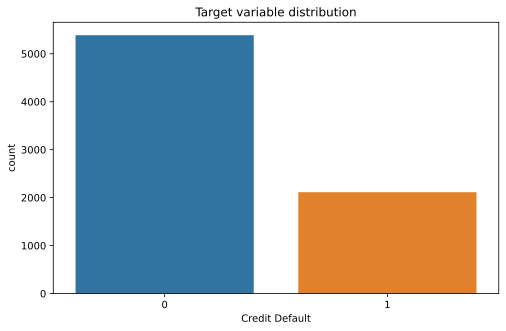

In [5]:
plt.figure(figsize=(8, 5))

sns.countplot(x = df['Credit Default'], data=df)

plt.title('Target variable distribution')
plt.show()

In [6]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Наблюдается дисбаланс классов

## Знакомство с вещественными признаками и исправление выбросов

### Home Ownership

In [7]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Преобразуем Home Ownerhip в категориальный признак

In [8]:
df["Home Ownership"] = df["Home Ownership"].astype('category')

df["Home Ownership"] = df["Home Ownership"].cat.codes

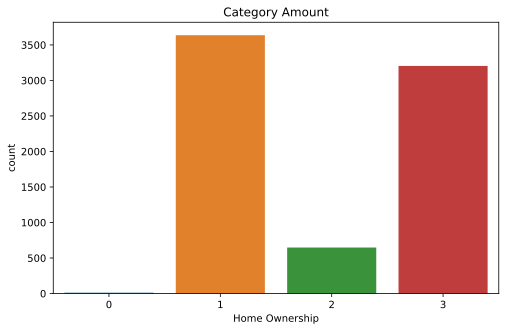

In [9]:
plt.figure(figsize=(8, 5))

sns.countplot(x = df['Home Ownership'], data=df)

plt.title('Category Amount')
plt.show()

### Annual Income

In [10]:
df['Annual Income'].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

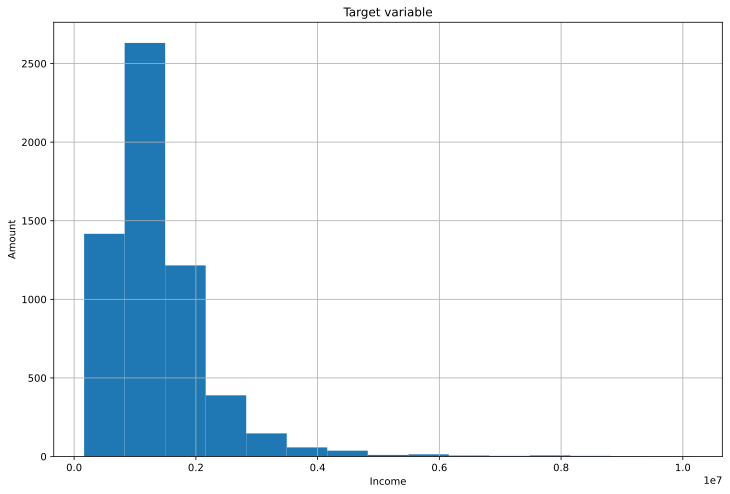

In [11]:
plt.figure(figsize = (12, 8))

df['Annual Income'].hist(bins=15)
plt.ylabel('Amount')
plt.xlabel('Income')

plt.title('Target variable')
plt.show()

Выбросов я не заметил, но решил отсечь чрезвычайно богатых

In [12]:
df.loc[df['Annual Income'] >= 5000000, 'Annual Income'] = df['Annual Income'].median()

## Years in current job

In [13]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Преобразуем 'Years in current job' в категориальную переменную

In [14]:
df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = '0'
df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = '1'
df.loc[df['Years in current job'] == '2 years', 'Years in current job'] = '2'
df.loc[df['Years in current job'] == '3 years', 'Years in current job'] = '3'
df.loc[df['Years in current job'] == '4 years', 'Years in current job'] = '4'
df.loc[df['Years in current job'] == '5 years', 'Years in current job'] = '5'
df.loc[df['Years in current job'] == '6 years', 'Years in current job'] = '6'
df.loc[df['Years in current job'] == '7 years', 'Years in current job'] = '7'
df.loc[df['Years in current job'] == '8 years', 'Years in current job'] = '8'
df.loc[df['Years in current job'] == '9 years', 'Years in current job'] = '9'
df.loc[df['Years in current job'] == '10 years', 'Years in current job'] = '10'
df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = '11'

In [15]:
df["Years in current job"] = df["Years in current job"].astype('category')

### Tax Liens 

In [16]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Все нормально

### Number of Open Accounts

In [17]:
df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

Не будем брать значения, где число больше 31

In [18]:
df.loc[df['Number of Open Accounts'] > 31, 'Number of Open Accounts'] = 31

In [19]:
df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
31.0     27
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
Name: Number of Open Accounts, dtype: int64

### Years of Credit History

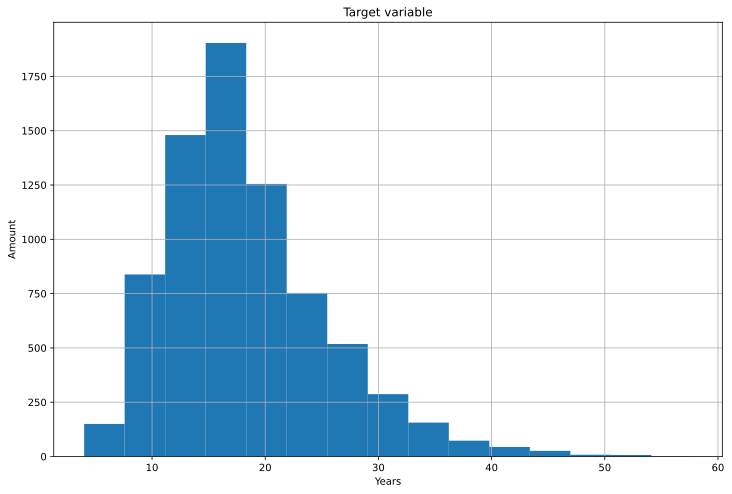

In [20]:
plt.figure(figsize = (12, 8))

df['Years of Credit History'].hist(bins=15)
plt.ylabel('Amount')
plt.xlabel('Years')

plt.title('Target variable')
plt.show()

Кажется, все норм

### Maximum Open Credit

In [21]:
df['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

Тут я заменяю значения, которые больше квантиля .84 на медиану

In [22]:
df.loc[df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.84), 'Maximum Open Credit'] = \
df['Maximum Open Credit'].median()

### Number of Credit Problems

In [23]:
df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [24]:
df.loc[df['Number of Credit Problems'] == 7.0, 'Number of Credit Problems'] = 6.0

Просто сделал меньше значений

### Bankruptcies

In [25]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [26]:
df.loc[df['Bankruptcies'] == 4.0, 'Bankruptcies'] = 3.0

Просто сделал меньше значений

### Purpose                       

In [27]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Преобразуем столбец Purpose в категорию

In [28]:
df["Purpose"] = df["Purpose"].astype('category')

df["Purpose"] = df["Purpose"].cat.codes

### Term

In [29]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [30]:
df["Term"] = df["Term"].astype('category')

df["Term"] = df["Term"].cat.codes

### Current Loan Amount

In [31]:
df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

Сумма кредита 99999999.0 явно выброс, заменим ее на медиану

In [32]:
df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df['Current Loan Amount'].median()

### Current Credit Balance

In [33]:
df['Current Credit Balance'].value_counts()

0.0         53
191710.0     5
53580.0      4
106818.0     4
155059.0     4
            ..
229672.0     1
349467.0     1
116223.0     1
797240.0     1
189905.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

Кажется, что все нормально

### Monthly Debt

In [34]:
df['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
9525.0     3
22364.0    3
          ..
12897.0    1
27541.0    1
23227.0    1
55957.0    1
17.0       1
Name: Monthly Debt, Length: 6716, dtype: int64

Monthly Debt не может быть равен 0. Я заменил 0 на Current Loan Amount деленное на 12 (на год)

In [35]:
df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = df['Current Loan Amount'] / 12
df.loc[df['Monthly Debt'] == 17, 'Monthly Debt'] = (df['Current Loan Amount'] - df['Current Credit Balance']) / 12

### Credit Score

In [36]:
df['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

In [37]:
df.loc[(df['Credit Score'] > 800) & (df['Credit Default'] == 1)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,1,1408527.0,2,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,9,0,525998.0,174135.0,9320.0,6470.0,1
87,1,1533566.0,7,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,3,1,210826.0,285475.0,18147.0,7440.0,1
94,3,1049294.0,3,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,0,1,337502.0,119529.0,15215.0,7010.0,1
96,3,757568.0,5,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,3,1,210518.0,276583.0,11553.0,7320.0,1
116,1,1039984.0,NaN,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,3,1,224246.0,95456.0,13780.0,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,3,694868.0,1,0.0,4.0,7.8,143066.0,0.0,NaN,0.0,3,0,244178.0,122075.0,4268.0,6690.0,1
7433,3,2011758.0,0,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,1,0,106480.0,18791.0,12590.0,6060.0,1
7450,1,1432277.0,11,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,3,1,187924.0,458242.0,27094.0,7290.0,1
7460,3,769462.0,5,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,3,1,109186.0,45524.0,4585.0,7470.0,1


Я заметил, что если Credit Score > 800, то Credit Default всегда равен 1. То ли это выброс, то ли фича

## Запихнем изменения в скрипты

In [38]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.MOC_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.MOC_quantile = X['Maximum Open Credit'].quantile(.84)
        
    def transform(self, X):
        """Трансформация данных"""

        # Home Ownership
        
        X["Home Ownership"] = X["Home Ownership"].astype('category')
        X["Home Ownership"] = X["Home Ownership"].cat.codes
        
        # Annual Income
        
        X.loc[X['Annual Income'] >= 5000000, 'Annual Income'] = X['Annual Income'].median()
        
        # Years in current job
        
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = '0'
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = '1'
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = '2'
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = '3'
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = '4'
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = '5'
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = '6'
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = '7'
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = '8'
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = '9'
        X.loc[X['Years in current job'] == '10 years', 'Years in current job'] = '10'
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = '11'
        
        # Number of Open Accounts
        
        X.loc[X['Number of Open Accounts'] > 31, 'Number of Open Accounts'] = 31
        
        # Maximum Open Credit
        
        X.loc[df['Maximum Open Credit'] > self.MOC_quantile, 'Maximum Open Credit'] = \
        X['Maximum Open Credit'].median()
        
        # Number of Credit Problems
        
        X.loc[X['Number of Credit Problems'] == 7.0, 'Number of Credit Problems'] = 6.0
        
        # Bankruptcies
        
        X.loc[X['Bankruptcies'] == 4.0, 'Bankruptcies'] = 3.0
        
        # Purpose
        
        X["Purpose"] = X["Purpose"].astype('category')
        X["Purpose"] = X["Purpose"].cat.codes
        
        # Term
        
        X["Term"] = X["Term"].astype('category')
        X["Term"] = X["Term"].cat.codes
        
        # Current Loan Amount
        
        X.loc[X['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = X['Current Loan Amount'].median()
        
        # Monthly Debt
        
        X.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = X['Current Loan Amount'] / 12
        X.loc[df['Monthly Debt'] == 17, 'Monthly Debt'] = (X['Current Loan Amount'] - X['Current Credit Balance']) / 12
        
        
        return X

## Заполнение пропусков

In [39]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

## Annual Income

In [40]:
df[pd.isnull(df['Annual Income'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,3,NaN,7,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,9,0,337304.0,165680.0,18692.000000,NaN,1
8,1,NaN,5,0.0,17.0,15.7,0.0,1.0,NaN,1.0,5,1,129734.0,19.0,10809.583333,NaN,0
9,1,NaN,1,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,3,0,572880.0,205333.0,17613.000000,NaN,1
10,1,NaN,0,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,3,1,220858.0,187492.0,14592.000000,NaN,0
16,3,NaN,7,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,3,0,313038.0,538346.0,18844.000000,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,1,NaN,11,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,3,1,188430.0,518662.0,23506.000000,NaN,0
7492,1,NaN,11,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,3,1,332948.0,161481.0,20966.000000,NaN,0
7494,2,NaN,0,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,3,1,290400.0,210938.0,5070.000000,NaN,0
7498,1,NaN,NaN,0.0,21.0,26.5,478159.0,0.0,NaN,0.0,3,1,615274.0,476064.0,37118.000000,NaN,0


In [41]:
condition = (df['Annual Income'].isna())

df.loc[condition, 'Annual Income'] = df['Annual Income'].median()

Заменил пропуски медианой

### Years in current job

In [42]:
condition = (df['Years in current job'].isna())

df.loc[condition, 'Years in current job'] = df['Years in current job'].mode()[0]

Заменил пропуски модой

### Months since last delinquent

Так как данных меньше половины, решил удалить столбец

In [43]:
df.drop('Months since last delinquent', axis=1, inplace=True)

### Bankruptcies                      

In [44]:
df[pd.isnull(df['Bankruptcies'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
100,2,337079.0,1,0.0,9.0,39.6,644204.0,0.0,NaN,4,1,309573.0,224770.0,4326.000000,734.0,0
256,3,857660.0,1,0.0,6.0,19.7,291082.0,0.0,NaN,3,1,309573.0,236816.0,3488.000000,743.0,0
257,1,1168386.0,2,0.0,15.0,13.6,478159.0,0.0,NaN,3,1,447480.0,524210.0,19613.000000,NaN,0
898,3,739005.0,2,0.0,20.0,18.3,478159.0,0.0,NaN,3,1,456808.0,607487.0,9669.000000,732.0,1
1404,3,349391.0,0,0.0,4.0,12.7,0.0,0.0,NaN,9,1,11242.0,0.0,1243.000000,747.0,0
3063,3,464474.0,11,0.0,5.0,14.9,38126.0,0.0,NaN,9,1,44814.0,18373.0,929.000000,7490.0,1
3252,3,832770.0,0,0.0,7.0,16.5,636856.0,0.0,NaN,0,1,156970.0,52250.0,1145.000000,750.0,0
3351,1,2226192.0,8,0.0,14.0,23.3,792836.0,0.0,NaN,3,1,528968.0,625157.0,23746.000000,674.0,0
3401,3,326154.0,6,0.0,2.0,19.1,0.0,0.0,NaN,9,1,309573.0,0.0,1245.000000,712.0,0
3496,3,233567.0,1,0.0,7.0,11.7,0.0,0.0,NaN,4,1,210166.0,0.0,17513.833333,746.0,0


In [45]:
condition = (df['Bankruptcies'].isna())

df.loc[condition, 'Bankruptcies'] = df['Bankruptcies'].mode()[0]

In [46]:
df['Bankruptcies'].mode()

0    0.0
dtype: float64

Заменил пропуски модой

### Credit Score

In [47]:
condition = (df['Credit Score'].isna())

df.loc[condition, 'Credit Score'] = df['Credit Score'].median()

In [48]:
df.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

## Корреляция с базовыми признаками

In [49]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

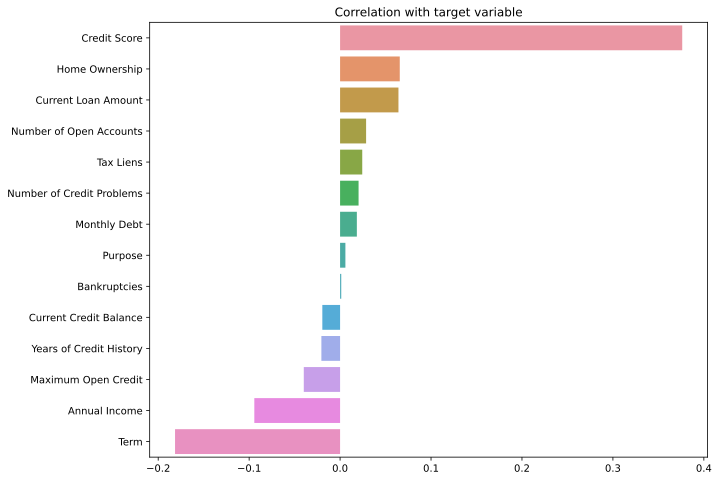

In [50]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [51]:
df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,482087.0,11,0.0,11.0,26.3,685960.0,1.0,1.0,3,1,309573.0,47386.0,7914.0,749.0,0
1,2,1025487.0,11,0.0,15.0,15.3,478159.0,0.0,0.0,3,0,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,8,0.0,11.0,35.0,478159.0,0.0,0.0,3,1,309573.0,308389.0,13651.0,742.0,0
3,2,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,3,1,121396.0,95855.0,11338.0,694.0,0
4,3,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,3,1,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,3,402192.0,0,0.0,3.0,8.5,107866.0,0.0,0.0,9,1,129360.0,73492.0,1900.0,697.0,0
7496,1,1533984.0,1,0.0,10.0,26.5,686312.0,0.0,0.0,3,0,444048.0,456399.0,12783.0,7410.0,1
7497,3,1878910.0,6,0.0,12.0,32.1,478159.0,0.0,0.0,1,1,309573.0,477812.0,12479.0,748.0,0
7498,1,1168386.0,11,0.0,21.0,26.5,478159.0,0.0,0.0,3,1,615274.0,476064.0,37118.0,731.0,0


In [52]:
df['is_score'] = (df['Credit Score'] > 800).astype(int)

## Скрипты Python для подготовки данных

In [53]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.MOC_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.MOC_quantile = X['Maximum Open Credit'].quantile(.84)
        
    def transform(self, X):
        """Трансформация данных"""

        # Home Ownership
        
        X["Home Ownership"] = X["Home Ownership"].astype('category')
        X["Home Ownership"] = X["Home Ownership"].cat.codes
        
        # Annual Income
        
        X.loc[X['Annual Income'] >= 5000000, 'Annual Income'] = X['Annual Income'].median()
        
        condition = (X['Annual Income'].isna())
        X.loc[condition, 'Annual Income'] = X['Annual Income'].median()
        
        # Years in current job
        
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = '0'
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = '1'
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = '2'
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = '3'
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = '4'
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = '5'
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = '6'
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = '7'
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = '8'
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = '9'
        X.loc[X['Years in current job'] == '10 years', 'Years in current job'] = '10'
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = '11'
        
        condition = (X['Years in current job'].isna())
        X.loc[condition, 'Years in current job'] = X['Years in current job'].mode()[0]
        
        # Number of Open Accounts
        
        X.loc[X['Number of Open Accounts'] > 31, 'Number of Open Accounts'] = 31
        
        # Maximum Open Credit
        
        X.loc[df['Maximum Open Credit'] > self.MOC_quantile, 'Maximum Open Credit'] = \
        X['Maximum Open Credit'].median()
        
        # Months since last delinquent
        
        X.drop('Months since last delinquent', axis=1, inplace=True)
        
        # Number of Credit Problems
        
        X.loc[X['Number of Credit Problems'] == 7.0, 'Number of Credit Problems'] = 6.0
        
        # Bankruptcies
        
        X.loc[X['Bankruptcies'] == 4.0, 'Bankruptcies'] = 3.0
        
        condition = (X['Bankruptcies'].isna())
        X.loc[condition, 'Bankruptcies'] = X['Bankruptcies'].mode()[0]
        
        # Purpose
        
        X["Purpose"] = X["Purpose"].astype('category')
        X["Purpose"] = X["Purpose"].cat.codes
        
        # Term
        
        X["Term"] = X["Term"].astype('category')
        X["Term"] = X["Term"].cat.codes
        
        # Current Loan Amount
        
        X.loc[X['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = X['Current Loan Amount'].median()
        
        # Monthly Debt
        
        X.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = X['Current Loan Amount'] / 12
        X.loc[df['Monthly Debt'] == 17, 'Monthly Debt'] = (X['Current Loan Amount'] - X['Current Credit Balance']) / 12
        
        # Credit Score
        
        condition = (X['Credit Score'].isna())
        X.loc[condition, 'Credit Score'] = X['Credit Score'].median()
        
        X['is_score'] = (X['Credit Score'] > 800).astype(int)
        
        
        return X

## Построение модели

### Отбор признаков

In [54]:
TARGET_NAME = 'Credit Default'

FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'is_score']

Приведение признаков для Catboost

In [55]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership               category
Years in current job         category
Tax Liens                    category
Number of Credit Problems    category
Bankruptcies                 category
Purpose                      category
Term                         category
is_score                     category
dtype: object

### Нормализация данных

In [56]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[FEATURE_NAMES] = scaler.fit_transform(df_norm[FEATURE_NAMES])

df = df_norm.copy()

### Разбиение данных на train и test

In [57]:
X = df[FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Функция для балансировки классов, как в уроке 3

In [58]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [59]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [60]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение модели Catboost

In [61]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

In [62]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Оценка модели

In [63]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3771
           1       0.94      0.84      0.89      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.90      0.90      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1616
           1       0.55      0.47      0.51       634

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                337  297


<BarContainer object of 16 artists>

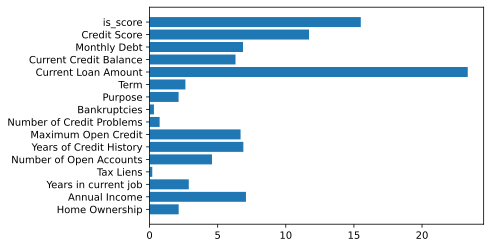

In [64]:
plt.barh(df.drop('Credit Default', axis=1).columns, model_catb.get_feature_importance())

## Педсказание на тестовых данных

### Подготовка данных

In [65]:
preprocessor = DataPreprocessing()
test_df = preprocessor.transform(test_df)

In [69]:
test_pred = model_catb.predict(test_df)
test_pred

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)